In [1]:
# import import_ipynb
from classes import *
import classes
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score



known_volume_path = 'C:/Users/GJ/Desktop/연구실/2022SPCUP/spcup_2022_training_part1'
unknown_volume_path = './spcup_2022_unseen'



rs = 10
known_path, known_labels = file_path_list(known_volume_path)
unknown_path, unknown_labels = file_path_list(unknown_volume_path)
##train set
# print('raw train_set_num :',len(labels))
X_train_path, X_test_path, y_train_raw, y_test_raw = train_test_split(np.array(known_path),
                                                                      known_labels, test_size=0.2,
                                                                      stratify = known_labels, random_state=rs)

n = -1
n_mels = 64
# train = classes.data(X_train_path,y_train_raw,n_mels=n_mels, known = True)
#
# test = classes.data(X_test_path,y_test_raw, n_mels=n_mels, known = True)
#
# unknown =data(unknown_path,unknown_labels, n_mels=n_mels, known = False)

train = classes.data(X_train_path[:n],y_train_raw[:n],n_mels=n_mels, known = True)

test = classes.data(X_test_path[:n],y_test_raw[:n], n_mels=n_mels, known = True)

unknown = data(unknown_path[:n],unknown_labels[:n], n_mels=n_mels, known = False)

train_au = train.flatten()
test_au = test.flatten()
unseen_au = unknown.flatten()

train.min_max_scale()
test.min_max_scale()
unknown.min_max_scale()

nb_epoch = 1000
batch_size = 64
input_dim = train_au.shape[1]
encoding_dim = 32
hidden_dim_1 = int(encoding_dim/2)
hidden_dim_2 = 8
learning_rate = 1e-7


input_layer = tf.keras.layers.Input(shape=(input_dim, ))
encoder = tf.keras.layers.Dense(encoding_dim, activation="tanh", activity_regularizer=tf.keras.regularizers.l1(learning_rate))(input_layer)
encoder= tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_2, activation='relu')(encoder)

decoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
decoder=tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(encoding_dim, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim, activation='tanh')(decoder)

autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

cp = tf.keras.callbacks.ModelCheckpoint(filepath=str(n_mels)+'_'+str(encoding_dim)+'_'+str(hidden_dim_2)
                                        +'_'+"autoencoder_best.h5", mode='auto', monitor='val_loss',
                                        verbose=2, save_best_only=True)

early_stop = tf.keras.callbacks.EarlyStopping( monitor='val_loss', min_delta=1e-4,
                                              patience=50, verbose=1, mode='min', restore_best_weights=True)


autoencoder.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')

history = autoencoder.fit(train_au, train_au, epochs=nb_epoch,
                         batch_size=batch_size, shuffle=True,
                          validation_split= 0.2, verbose=1,
                          callbacks=[cp, early_stop] ).history


plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='val')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch') #plt.ylim(ymin=0.70,ymax=1) plt.show()
plt.show()

test_x_predictions = autoencoder.predict(test_au)
mse_test = np.mean(np.power(test_au - test_x_predictions, 2), axis=1)
# error_df = pd.DataFrame({'Reconstruction_error': mse_test, 'True_class': test.labels})


unseen_x_predictions = autoencoder.predict(unseen_au)
mse_unseen = np.mean(np.power(unseen_au - unseen_x_predictions, 2), axis=1)
# error_df = pd.DataFrame({'Reconstruction_error': mse_unseen, 'True_class': test.labels})

all_mse = np.concatenate((mse_test,mse_unseen),axis = None)

plt.subplot()
plt.plot(all_mse)
plt.show()


KeyboardInterrupt: 

In [40]:
from tensorflow.keras.models import load_model
autoencoder = load_model('./models_log/14_4_autoencoder_fraud.h5',custom_objects={'leaky_relu': tf.nn.leaky_relu})
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
dense (Dense)                (None, 14)                28686     
_________________________________________________________________
dropout (Dropout)            (None, 14)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 105       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 32        
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 35        
_________________________________________________________________
dropout_1 (Dropout)          (None, 7)                 0     

In [47]:
print(test.file_split_num)

[8, 7, 7, 8, 9, 11, 10, 6, 4, 8, 5, 12, 9, 5, 14, 2, 9, 3, 7, 6, 2, 2, 5, 6, 4, 3, 4, 7, 3, 9, 9, 4, 5, 7, 5, 7, 8, 7, 13, 5, 4, 8, 6, 8, 6, 7, 1, 9, 8, 8, 9, 3, 8, 6, 10, 3, 4, 6, 10, 5, 6, 7, 6, 9, 7, 7, 8, 2, 3, 4, 3, 6, 11, 3, 5, 2, 6, 7, 4, 7, 2, 9, 7, 12, 6, 8, 4, 7, 7, 6, 4, 4, 6, 3, 2, 11, 7, 6, 8, 3, 9, 7, 6, 5, 2, 10, 8, 5, 9, 6, 10, 5, 5, 7, 8, 8, 7, 4, 3, 5, 6, 7, 6, 9, 5, 8, 6, 3, 6, 7, 2, 7, 6, 6, 8, 12, 6, 10, 9, 5, 2, 4, 11, 7, 7, 6, 8, 4, 8, 3, 5, 10, 11, 11, 6, 10, 10, 7, 6, 6, 10, 4, 10, 8, 4, 8, 11, 5, 3, 7, 5, 7, 5, 8, 2, 4, 6, 6, 11, 6, 2, 5, 8, 8, 5, 9, 3, 6, 7, 4, 6, 7, 9, 9, 4, 11, 9, 7, 10, 6, 4, 3, 1, 6, 3, 4, 5, 6, 7, 5, 10, 8, 8, 8, 3, 7, 12, 4, 6, 6, 5, 5, 3, 4, 4, 5, 7, 6, 9, 6, 4, 5, 4, 4, 10, 9, 5, 5, 8, 4, 9, 9, 5, 8, 4, 4, 5, 6, 7, 7, 2, 4, 4, 2, 5, 10, 6, 8, 4, 4, 2, 11, 6, 4, 9, 7, 5, 5, 3, 8, 6, 6, 3, 6, 4, 8, 10, 6, 6, 5, 3, 5, 5, 4, 2, 8, 8, 5, 9, 4, 7, 6, 2, 9, 5, 9, 6, 6, 4, 11, 2, 6, 8, 5, 8, 8, 3, 7, 10, 3, 3, 8, 8, 10, 7, 4, 9, 5, 8, 6, 5, 6

In [85]:
from scipy.stats import mode
test_x_predictions = autoencoder.predict(test_au)
mse_test = np.mean(np.power(test_au - test_x_predictions, 2), axis=1)
# error_df = pd.DataFrame({'Reconstruction_error': mse_test, 'True_class': test.labels})


unseen_x_predictions = autoencoder.predict(unseen_au)
mse_unseen = np.mean(np.power(unseen_au - unseen_x_predictions, 2), axis=1)

all_mse = np.concatenate((mse_test,mse_unseen),axis = None)

def seg_acc(mse,labels, threshold, known = True):
    if known == True:
        thresh = mse[mse>threshold]
    else:
        thresh = mse[mse< threshold]
    return (len(thresh)/len(mse))

def file_acc(mse, file_split_num,labels, threshold):
    f = 0
    prediction=[]
    for i in file_split_num:
    #     print(predicted_classes[f:f+i])
        file_mse = mse[f:f+i]
#         print(file_mse)
        thresh = file_mse[file_mse < threshold]
        print(thresh)
        prediction = len(thresh)/len(file_mse)
#         f+=i

#     acc_bool = prediction==labels
#     print(acc_bool)
#     #             print(test_predict[:100])
#     #             print(y_test_raw[:100])
#     #             print(acc_bool[:100])
#     test_accuracy = acc_bool.count(True)/len(acc_bool)
    return test_accuracy

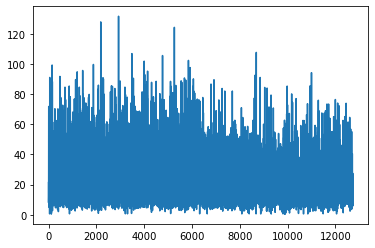

In [89]:
plt.plot(np.sqrt(all_mse))

In [86]:
for thresh in range(400,8000,100):
    print('thresh : ', thresh)
    print('test_acc : ', seg_acc(mse_test,np.zeros(len(mse_test)), thresh, True))
    print('unseen_acc : ', seg_acc(mse_unseen,np.ones(len(mse_test)), thresh, False))
    print('\n')

thresh :  400
test_acc :  0.5221362229102167
unseen_acc :  0.5630278884462151


thresh :  500
test_acc :  0.45712074303405575
unseen_acc :  0.6360159362549801


thresh :  600
test_acc :  0.41099071207430343
unseen_acc :  0.694980079681275


thresh :  700
test_acc :  0.37708978328173376
unseen_acc :  0.7451792828685259


thresh :  800
test_acc :  0.3455108359133127
unseen_acc :  0.7823107569721115


thresh :  900
test_acc :  0.3157894736842105
unseen_acc :  0.8098804780876494


thresh :  1000
test_acc :  0.29226006191950465
unseen_acc :  0.8334661354581673


thresh :  1100
test_acc :  0.2736842105263158
unseen_acc :  0.8548207171314741


thresh :  1200
test_acc :  0.2561919504643963
unseen_acc :  0.8707569721115538


thresh :  1300
test_acc :  0.23653250773993809
unseen_acc :  0.8866932270916335


thresh :  1400
test_acc :  0.2212074303405573
unseen_acc :  0.8999203187250996


thresh :  1500
test_acc :  0.2068111455108359
unseen_acc :  0.9112350597609562


thresh :  1600
test_acc :  0.1

In [69]:
for thresh in range(400,8000,100):
    test_acc = file_acc(mse_test,test.file_split_num, test.labels_flatten, thresh)
    print(test_acc)

[452.76364 784.09033]
[452.76364 784.09033]
[452.76364 784.09033]
[452.76364 784.09033]
[ 452.76364  784.09033 5149.0596 ]
[ 452.76364  784.09033 5149.0596  1096.7462  1430.663  ]
[ 452.76364  784.09033 5149.0596  1096.7462 ]
[452.76364]
[452.76364]
[452.76364 784.09033]
[452.76364]
[ 452.76364  784.09033 5149.0596  1096.7462  1430.663  ]
[ 452.76364  784.09033 5149.0596 ]
[452.76364]
[ 452.76364  784.09033 5149.0596  1096.7462  1430.663   1020.56964]
[452.76364]
[ 452.76364  784.09033 5149.0596 ]
[452.76364]
[452.76364 784.09033]
[452.76364]
[452.76364]
[452.76364]
[452.76364]
[452.76364]
[452.76364]
[452.76364]
[452.76364]
[452.76364 784.09033]
[452.76364]
[ 452.76364  784.09033 5149.0596 ]
[ 452.76364  784.09033 5149.0596 ]
[452.76364]
[452.76364]
[452.76364 784.09033]
[452.76364]
[452.76364 784.09033]
[452.76364 784.09033]
[452.76364 784.09033]
[ 452.76364  784.09033 5149.0596  1096.7462  1430.663  ]
[452.76364]
[452.76364]
[452.76364 784.09033]
[452.76364]
[452.76364 784.09033]
[4

NameError: name 'test_accuracy' is not defined

In [15]:
test_acc = file_acc(mse_test, test.file_split_num,y_test_raw)
# unseen_acc = file_acc(mse_unseen, unknown.file_split_num, unknown.labels)

AttributeError: 'numpy.ndarray' object has no attribute 'file_split_num'

In [2]:

nb_epoch = 50 
batch_size = 64 
input_dim = normal_train_data.shape[1]

input_layer = tf.keras.layers.Input(shape=(input_dim, ))
encoder = tf.keras.layers.Dense(encoding_dim, activation="tanh", activity_regularizer=tf.keras.regularizers.l2(learning_rate))(input_layer) 
encoder= tf.keras.layers.Dropout(0.2)(encoder) 
encoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder) 
encoder = tf.keras.layers.Dense(hidden_dim_2, activation=tf.nn.leaky_relu)(encoder)

decoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
decoder=tf.keras.layers.Dropout(0.2)(decoder) 
decoder = tf.keras.layers.Dense(encoding_dim, activation='relu')(decoder) 
decoder = tf.keras.layers.Dense(input_dim, activation='tanh')(decoder)

autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder) 
autoencoder.summary()

cp = tf.keras.callbacks.ModelCheckpoint(filepath="autoencoder_fraud.h5", mode='min', monitor='val_loss',
                                        verbose=2, save_best_only=True) 

early_stop = tf.keras.callbacks.EarlyStopping( monitor='val_loss', min_delta=0.0001, 
                                              patience=10, verbose=1, mode='min', restore_best_weights=True


autoencoder.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')

history = autoencoder.fit(normal_train_data, normal_train_data, epochs=nb_epoch, 
                          batch_size=batch_size, shuffle=True, 
                          validation_data=(test_data, test_data), verbose=1, 
                          callbacks=[cp, early_stop] ).history


plt.plot(history['loss'], linewidth=2, label='Train') 
plt.plot(history['val_loss'], linewidth=2, label='Test') 
plt.legend(loc='upper right') 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') #plt.ylim(ymin=0.70,ymax=1) plt.show()


test_x_predictions = autoencoder.predict(test_data) 
mse = np.mean(np.power(test_data - test_x_predictions, 2), axis=1) 
error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': test_labels})


                                              

SyntaxError: invalid syntax (<ipython-input-2-acc787532675>, line 27)